In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from config_store import features, targetDataSet
from utility_functions import dataSetSplit, doKFold, score

In [11]:
# Import and preview data set
data = pd.read_csv(targetDataSet)
data.head()

,Website,Length,Protocol,Info
0,0,66,1,4
1,0,66,1,1
2,0,54,1,6
3,0,712,0,12
4,0,1490,0,8


In [12]:
# Separate data set using test/train split
XTrain, XTest, yTrain, yTest = dataSetSplit(data.drop(columns = ["Website"]).values, data["Website"].values)

In [13]:
# Perform k-fold to optimize alpha hyperparameter
alphaRange = np.linspace(0.005, 1, 100)

# Hold k-fold result for each possible k neighbor value
train = []
test = []
    
for alpha in alphaRange:
    rid_reg = Lasso(alpha=alpha)
    trainResult, testResult = doKFold(rid_reg, XTrain, yTrain)
        
    train.append(np.mean(trainResult))
    test.append(np.mean(testResult))

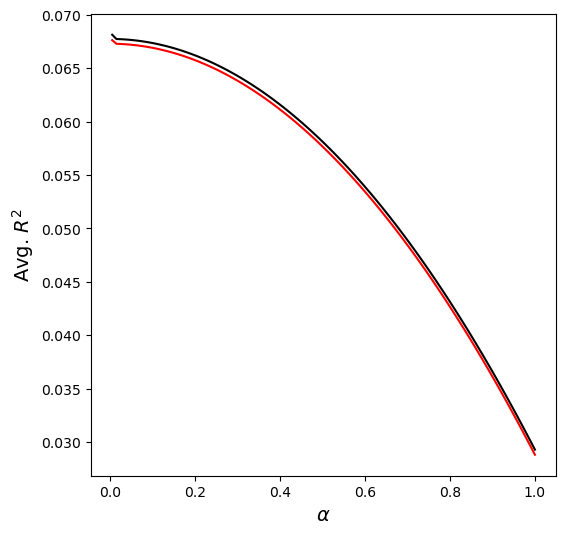

In [14]:
plt.figure(figsize=(6,6))
plt.plot(alphaRange, train, color='k', label='Training')
plt.plot(alphaRange, test, color='r', label='Testing')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Avg. $R^2$', fontsize=14)
plt.show()

In [15]:
# Get optimal hyperparameter for lasso
maxIndex = (test == np.max(test))
print(alphaRange[maxIndex])
print(np.max(test))
print(np.max(train))

[0.005]
0.06763592601508789
0.06814630942524608


In [16]:
# Final lasso model
lasso = Lasso(alpha=alphaRange[maxIndex][0])
lasso.fit(XTrain, yTrain)

Lasso(alpha=0.005)

In [17]:
# Score model
print("Model scores:")
score(lasso, XTrain, yTrain, XTest, yTest)

Model scores:
Training score: 0.06813833607663855
Testing score: 0.06173778127048868


In [18]:
# Report feature importance
print("Feature importance:")
for i in range(len(lasso.coef_)):
    print("{}    \t{}".format(features[i], lasso.coef_[i]))

Feature importance:
Length    	8.901836542185771e-05
Protocol    	0.06359984692651052
Info    	-0.06973922956884926
